In [83]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization, \
    Flatten, Dense, Reshape, Conv2DTranspose, Activation, Lambda
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.metrics as Metrics
from tensorflow.keras.losses import MeanSquaredError, KLDivergence
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
#import ddsp
#import gin
import soundfile as sf
import librosa
import pickle
import hub
import io
import os
import unicodedata
import string
import glob
import random
print(tf.version)
tf.compat.v1.disable_eager_execution()

<module 'tensorflow._api.v2.version' from '/Users/Ry1/miniconda3/envs/AMTFinalProj/lib/python3.9/site-packages/tensorflow/_api/v2/version/__init__.py'>


In [14]:
from tensorflow.keras import datasets, layers, models
# load dataset
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
# normalize pixel values
train_images, test_images = train_images / 255.0, test_images / 255.0
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

170508288/170498071 [==============================] - 9s 0us/step


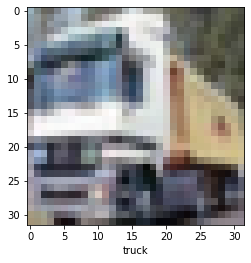

In [17]:
# look at an image
IMG_INDEX = 1 # image to look at

plt.imshow(train_images[IMG_INDEX], cmap=plt.cm.binary)
plt.xlabel(class_names[train_labels[IMG_INDEX][0]])
plt.show()

In [19]:
# build convolutional base
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
Total params: 56,320
Trainable params: 56,320
Non-trai

In [20]:
# add dense layers
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 1024)             

In [21]:
# train model
model.compile(optimizer='adam', 
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(train_images, train_labels, epochs=4, 
                   validation_data=(test_images, test_labels))

Epoch 1/4
1563/1563 [==============================] - 23s 15ms/step - loss: 1.5004 - accuracy: 0.4544 - val_loss: 1.2847 - val_accuracy: 0.5261
Epoch 2/4
1563/1563 [==============================] - 23s 15ms/step - loss: 1.1490 - accuracy: 0.5935 - val_loss: 1.1397 - val_accuracy: 0.5990
Epoch 3/4
1563/1563 [==============================] - 27s 17ms/step - loss: 0.9966 - accuracy: 0.6501 - val_loss: 1.0206 - val_accuracy: 0.6423
Epoch 4/4
1563/1563 [==============================] - 25s 16ms/step - loss: 0.8989 - accuracy: 0.6838 - val_loss: 0.9285 - val_accuracy: 0.6706


In [22]:
# evaluate model
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(test_acc)

313/313 - 1s - loss: 0.9285 - accuracy: 0.6706 - 945ms/epoch - 3ms/step
0.6705999970436096


In [24]:
## Movie Reviews
from keras.datasets import imdb
from keras.preprocessing import sequence

VOCAB_SIZE = 88584
MAXLEN = 250
BATCH_SIZE = 64

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words = VOCAB_SIZE)
train_data[0]

17473536/17464789 [==============================] - 1s 0us/step


[1,
 14,
 22,
 16,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 22665,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 21631,
 336,
 385,
 39,
 4,
 172,
 4536,
 1111,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2025,
 19,
 14,
 22,
 4,
 1920,
 4613,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 1247,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 19193,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2223,
 5244,
 16,
 480,
 66,
 3785,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 1415,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 10311,
 8,
 4,
 107,
 117,
 5952,
 15,
 256,
 4,
 31050,
 7,
 3766,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 12118,
 1029,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2071,
 56,
 26,
 141,
 6,
 194,
 7486,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5

In [26]:
# make lengths uniform
train_data = sequence.pad_sequences(train_data, MAXLEN)
test_data = sequence.pad_sequences(test_data, MAXLEN)
train_data[0]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     1,    14,    22,    16,
          43,   530,   973,  1622,  1385,    65,   458,  4468,    66,
        3941,     4,   173,    36,   256,     5,    25,   100,    43,
         838,   112,    50,   670, 22665,     9,    35,   480,   284,
           5,   150,     4,   172,   112,   167, 21631,   336,   385,
          39,     4,   172,  4536,  1111,    17,   546,    38,    13,
         447,     4,   192,    50,    16,     6,   147,  2025,    19,
          14,    22,     4,  1920,  4613,   469,     4,    22,    71,
          87,    12,    16,    43,   530,    38,    76,    15,    13,
        1247,     4,    22,    17,   515,    17,    12,    16,   626,
          18, 19193,     5,    62,   386,    12,     8,   316,     8,
         106,     5,

In [27]:
# create the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE, 32),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          2834688   
                                                                 
 lstm (LSTM)                 (None, 32)                8320      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,843,041
Trainable params: 2,843,041
Non-trainable params: 0
_________________________________________________________________


In [28]:
# training
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc'])
history = model.fit(train_data, train_labels, epochs=10, validation_split=0.2)

Epoch 1/10
625/625 [==============================] - 28s 43ms/step - loss: 0.4225 - acc: 0.8081 - val_loss: 0.3041 - val_acc: 0.8752
Epoch 2/10
625/625 [==============================] - 30s 48ms/step - loss: 0.2429 - acc: 0.9073 - val_loss: 0.2862 - val_acc: 0.8770
Epoch 3/10
625/625 [==============================] - 32s 51ms/step - loss: 0.1907 - acc: 0.9316 - val_loss: 0.3175 - val_acc: 0.8588
Epoch 4/10
625/625 [==============================] - 29s 47ms/step - loss: 0.1573 - acc: 0.9446 - val_loss: 0.3042 - val_acc: 0.8834
Epoch 5/10
625/625 [==============================] - 29s 47ms/step - loss: 0.1314 - acc: 0.9530 - val_loss: 0.3013 - val_acc: 0.8846
Epoch 6/10
625/625 [==============================] - 30s 48ms/step - loss: 0.1135 - acc: 0.9609 - val_loss: 0.2882 - val_acc: 0.8890
Epoch 7/10
625/625 [==============================] - 34s 55ms/step - loss: 0.0991 - acc: 0.9671 - val_loss: 0.3028 - val_acc: 0.8842
Epoch 8/10
625/625 [==============================] - 44s 71ms

In [29]:
# evaluation
results = model.evaluate(test_data, test_labels)
print(results)

782/782 [==============================] - 9s 11ms/step - loss: 0.4238 - acc: 0.8578
[0.42381909489631653, 0.8578400015830994]


In [32]:
# encode and decode words
word_index = imdb.get_word_index()

def encode_text(text):
    tokens = tf.keras.preprocessing.text.text_to_word_sequence(text)
    tokens = [word_index[word] if word in word_index else 0 for word in tokens]
    return sequence.pad_sequences([tokens], MAXLEN)[0]

text = "that movie was just amazing, so amazing"
encoded = encode_text(text)
print(encoded)

reverse_word_index = {value: key for (key,value) in word_index.items()}

def decode_integers(integers):
    PAD = 0
    text = ""
    for num in integers:
        if num != PAD:
            text += reverse_word_index[num] + " "
    return text[:-1]

print(decode_integers(encoded))

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0  12  17  13  4

In [33]:
# make a prediction
def predict(text):
    encoded_text = encode_text(text)
    pred = np.zeros((1,250))
    pred[0] = encoded_text
    result = model.predict(pred)
    print(result[0])
    
positive_review = "That movie was so awesome! I really loved it and would watch it again because it was amazingly great"
predict(positive_review)

negative_review = "that movie sucked. I hated it and wouldn't watch it again. Was one of the worst things I've ever watched"
predict(negative_review)

[0.731589]
[0.08664086]


In [36]:
## Play Generator
# read
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
print('Length of text: {} characters'.format(len(text)))
print(text[:250])

Length of text: 1115394 characters
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [37]:
# encode
vocab = sorted(set(text))
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

def text_to_int(text):
    return np.array([char2idx[c] for c in text])

text_as_int = text_to_int(text)

print("Text:", text[:13])
print("Encoded:", text_to_int(text[:13]))

Text: First Citizen
Encoded: [18 47 56 57 58  1 15 47 58 47 64 43 52]


In [39]:
# decode
def int_to_text(ints):
    try:
        ints = ints.numpy()
    except:
        pass
    return ''.join(idx2char[ints])

print(int_to_text(text_as_int[:13]))

First Citizen


In [42]:
# create training examples
seq_length = 100 # length of sequence for training example
examples_per_epoch = len(text)//(seq_length+1)

char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

for x,y in dataset.take(2):
    print("\n\nEXAMPLE\n")
    print("INPUT")
    print(int_to_text(x))
    print("\nOUTPUT")
    print(int_to_text(y))



EXAMPLE

INPUT
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You

OUTPUT
irst Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You 


EXAMPLE

INPUT
are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you 

OUTPUT
re all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you k


In [43]:
# make training batches
BATCH_SIZE = 64
VOCAB_SIZE = len(vocab)
EMBEDDING_DIM = 256
RNN_UNITS = 1024

BUFFER_SIZE = 1000

data = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

In [44]:
# build the model
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, 
                                  batch_input_shape=[batch_size, None]),
        tf.keras.layers.LSTM(rnn_units,
                            return_sequences=True, 
                            stateful=True,
                            recurrent_initializer='glorot_uniform'),
        tf.keras.layers.Dense(vocab_size)
    ])
    return model

model = build_model(VOCAB_SIZE, EMBEDDING_DIM, RNN_UNITS, BATCH_SIZE)
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (64, None, 256)           16640     
                                                                 
 lstm_1 (LSTM)               (64, None, 1024)          5246976   
                                                                 
 dense_3 (Dense)             (64, None, 65)            66625     
                                                                 
Total params: 5,330,241
Trainable params: 5,330,241
Non-trainable params: 0
_________________________________________________________________


In [54]:
# create loss function
for input_example_batch, target_example_batch in data.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape)

print(len(example_batch_predictions[0][0]))
print(example_batch_predictions[0][0])

sampled_indices  = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = np.reshape(sampled_indices, (1, -1))[0]
predicted_chars = int_to_text(sampled_indices)
print(predicted_chars)

def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

(64, 100, 65)
65
tf.Tensor(
[-4.51658014e-03 -9.77291819e-03 -4.71461564e-03 -5.24241757e-03
  5.14366431e-03  2.45383568e-03  4.25662845e-03  3.97188170e-03
 -7.72761786e-03  3.44890892e-03 -1.38357584e-03 -1.15006203e-02
  7.87431374e-04  5.21099754e-03 -1.50419981e-03 -1.36383548e-02
  8.53172969e-04  7.59544130e-03  9.89117194e-03 -5.85319381e-03
  1.08037163e-02  3.04333726e-03 -1.18264416e-03 -1.17904227e-02
 -1.47772087e-02  5.78749459e-05 -3.48654762e-03  3.23198875e-03
  1.63888442e-03  3.76582076e-03 -1.00552784e-02 -2.65365792e-03
 -1.11259520e-04 -2.19564070e-04 -9.80902230e-04 -5.99937793e-03
 -6.53524743e-03 -2.43942812e-03  7.97118433e-03  3.82491155e-03
  7.35105621e-03 -1.32041713e-02 -1.66153605e-03  1.06117595e-02
  1.58883503e-03 -1.86012010e-03  4.19293437e-03 -8.95275641e-03
  4.92752064e-04  2.50241440e-03 -8.10209196e-03 -8.07052292e-03
 -8.63911863e-03 -1.23202903e-02  2.86776666e-03  8.49582255e-03
  6.05749805e-03 -4.35196969e-04 -8.27114098e-03 -4.45112912e-

In [55]:
# compile the model
model.compile(optimizer='adam', loss=loss)

In [57]:
# create checkpoints
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix, save_weights_only=True)

In [58]:
# train model
history = model.fit(data, epochs=40, callbacks=[checkpoint_callback])

Epoch 1/40
172/172 [==============================] - 343s 2s/step - loss: 2.5806
Epoch 2/40
172/172 [==============================] - 368s 2s/step - loss: 1.9048
Epoch 3/40
172/172 [==============================] - 368s 2s/step - loss: 1.6598
Epoch 4/40
172/172 [==============================] - 353s 2s/step - loss: 1.5212
Epoch 5/40
172/172 [==============================] - 357s 2s/step - loss: 1.4352
Epoch 6/40
172/172 [==============================] - 348s 2s/step - loss: 1.3751
Epoch 7/40
172/172 [==============================] - 346s 2s/step - loss: 1.3303
Epoch 8/40
172/172 [==============================] - 362s 2s/step - loss: 1.2884
Epoch 9/40
172/172 [==============================] - 344s 2s/step - loss: 1.2519
Epoch 10/40
172/172 [==============================] - 308s 2s/step - loss: 1.2172
Epoch 11/40
172/172 [==============================] - 281s 2s/step - loss: 1.1817
Epoch 12/40
172/172 [==============================] - 281s 2s/step - loss: 1.1449
Epoch 13/40
1

In [62]:
# load the model
model = build_model(VOCAB_SIZE, EMBEDDING_DIM, RNN_UNITS, batch_size=1)
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))

In [60]:
checkpoint_num = 10
model.load_weights(tf.train.load_checkpoint("./training_checkpoints/ckpt_" + str(checkpoint_num)))
model.build(tf.TensorShape([1, None]))

AttributeError: 'tensorflow.python.util._pywrap_checkpoint_reader.C' object has no attribute 'endswith'

In [61]:
str(checkpoint_num)

'10'

In [69]:
# generate text
def generate_text(model, start_string):
    
    num_generate = 800 # number of characters to generate
    
    input_eval = [char2idx[s] for s in start_string] # convert starting string to numbers
    input_eval = tf.expand_dims(input_eval, 0)
    
    text_generated = [] # empty string to store results
    
    temperature = 0.5 # predictable vs. surprising text
    model.reset_states()
    
    for i in range(num_generate):
        predictions = model(input_eval)
        predictions = tf.squeeze(predictions, 0) # remove the batch dimension
        predictions = predictions / temperature
        
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1, 0].numpy()
        
        input_eval = tf.expand_dims([predicted_id], 0)
        
        text_generated.append(idx2char[predicted_id])
        
    return(start_string + ''.join(text_generated))

In [71]:
inp = input("Type a starting string: ")
print(generate_text(model, inp))

Type a starting string: balyhoo
balyhood to usurper and success;
Where, for the foolish chance of their death
And come have said, and hearden thee,
I have the foul way I bear my state.

CLARENCE:
All men arrested and such a lady?

Provost:
To him, and Prince of Watchmuned Henry! wilt thou lave me stay,
To make the bride appearants two be few,
Signior Baptista, first begin with her.

PETRUCHIO:
Shooth thy life and lowls with an and credit of the north,
To see a traitor and in judgment that my path were at him.

KATHARINA:
I charge you, sir, they are come.

ANTONIO:
The very mercy is your sister.

ANTONIO:
That sort was well fished for.

GONZALO:
This should be mine own.

PROSPERO:
O, was she so it in so strong-husband and honour,
To hear the senate-house but a fresh and a suitor to the state,
That makes him closely bend thee wit


In [95]:
## CNN with PyTorch
device = torch.device('cpu') # device config
num_epochs = 4 # hyper parameters
batch_size = 4
learning_rate = 0.001

# transform and load datasets
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


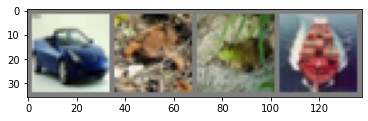

In [96]:
# show images
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

In [102]:
# implement CNN
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # -> n, 3, 32, 32
        x = self.pool(F.relu(self.conv1(x)))  # -> n, 6, 14, 14
        x = self.pool(F.relu(self.conv2(x)))  # -> n, 16, 5, 5
        x = x.view(-1, 16 * 5 * 5)            # -> n, 400
        x = F.relu(self.fc1(x))               # -> n, 120
        x = F.relu(self.fc2(x))               # -> n, 84
        x = self.fc3(x)                       # -> n, 10
        return x
    
model = ConvNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
n_total_steps = len(train_loader)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1)%2000 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}' )
            
print('Finished Training')

PATH = './cnn.pth'
torch.save(model.state_dict(), PATH)

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

Epoch [1/4], Step [2000/12500], Loss: 2.3131
Epoch [1/4], Step [4000/12500], Loss: 2.2874
Epoch [1/4], Step [6000/12500], Loss: 2.2721
Epoch [1/4], Step [8000/12500], Loss: 2.3069
Epoch [1/4], Step [10000/12500], Loss: 2.2902
Epoch [1/4], Step [12000/12500], Loss: 2.2673
Epoch [2/4], Step [2000/12500], Loss: 2.2713
Epoch [2/4], Step [4000/12500], Loss: 2.0849
Epoch [2/4], Step [6000/12500], Loss: 2.2950
Epoch [2/4], Step [8000/12500], Loss: 2.1467
Epoch [2/4], Step [10000/12500], Loss: 1.7121
Epoch [2/4], Step [12000/12500], Loss: 1.2372
Epoch [3/4], Step [2000/12500], Loss: 1.8280
Epoch [3/4], Step [4000/12500], Loss: 1.2699
Epoch [3/4], Step [6000/12500], Loss: 1.3413
Epoch [3/4], Step [8000/12500], Loss: 1.2124
Epoch [3/4], Step [10000/12500], Loss: 1.0239
Epoch [3/4], Step [12000/12500], Loss: 2.2983
Epoch [4/4], Step [2000/12500], Loss: 1.9875
Epoch [4/4], Step [4000/12500], Loss: 1.3357
Epoch [4/4], Step [6000/12500], Loss: 1.6394
Epoch [4/4], Step [8000/12500], Loss: 1.0068
Epoc

In [97]:
next(iter(train_loader))

[tensor([[[[ 0.7176,  0.7098,  0.7176,  ...,  0.6941,  0.6784,  0.7176],
           [-0.4588, -0.4196, -0.4275,  ..., -0.4196, -0.4510, -0.4902],
           [-0.8118, -0.7176, -0.7490,  ..., -0.6314, -0.6000, -0.6549],
           ...,
           [ 0.6235,  0.5373,  0.4902,  ...,  0.5216,  0.5294,  0.6000],
           [ 0.6314,  0.6157,  0.6314,  ...,  0.7098,  0.6471,  0.6078],
           [ 0.4510,  0.4353,  0.4980,  ...,  0.7725,  0.7725,  0.6941]],
 
          [[ 0.7569,  0.7569,  0.7647,  ...,  0.7412,  0.7255,  0.7647],
           [-0.3490, -0.3098, -0.3255,  ..., -0.3176, -0.3490, -0.3804],
           [-0.7020, -0.6157, -0.6471,  ..., -0.5294, -0.4980, -0.5529],
           ...,
           [ 0.7333,  0.6471,  0.6078,  ...,  0.6627,  0.6157,  0.6706],
           [ 0.6627,  0.6471,  0.6549,  ...,  0.7412,  0.6706,  0.6235],
           [ 0.4588,  0.4431,  0.4980,  ...,  0.7725,  0.7725,  0.7020]],
 
          [[ 0.7176,  0.7176,  0.7255,  ...,  0.7020,  0.6863,  0.7255],
           [-

In [105]:
## RNN with PyTorch

# Utils

ALL_LETTERS = string.ascii_letters + ".,;"
N_LETTERS = len(ALL_LETTERS)

def unicode_to_ascii(s):
    return ''.join(
    c for c in unicodedata.normalize('NFD', s)
    if unicodedata.category(c) != 'MN'
    and c in ALL_LETTERS)

def load_data():
    # Build the category_lines dictionary, a list of names per language
    category_lines = {}
    all_categories = []
    
    def find_files(path):
        return glob.glob(path)
    
    # Read a file and split into lines
    def read_lines(filename):
        lines = io.open(filename, encoding='utf-8').read().strip().split('\n')
        return [unicode_to_ascii(line) for line in lines]
    
    for filename in find_files('data/names/*.txt'):
        category = os.path.splitext(os.path.basename(filename))[0]
        all_categories.append(category)
        
        lines = read_lines(filename)
        category_lines[category] = lines
        
    return category_lines, all_categories

# Find letter index from all_letters, e.g. "a" = 0
def letter_to_index(letter):
    return ALL_LETTERS.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letter_to_tensor(letter):
    tensor = torch.zeros(1, N_LETTERS)
    tensor[0][letter_to_index(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, N_LETTERS)
    for i, letter in enumerate(line):
        tensor[i][0][letter_to_index(letter)] = 1
    return tensor

def random_training_example(category_lines, all_categories):
    
    def random_choice(a):
        random_idx = random.randint(0, len(a) - 1)
        return a[random_idx]
    
    category = random_choice(all_categories)
    line = random_choice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = line_to_tensor(line)
    return category, line, category_tensor, line_tensor

In [113]:
# Implement RNN
class RNN(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input_tensor, hidden_tensor):
        combined = torch.cat((input_tensor, hidden_tensor), 1)
        
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden
    
    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)
    
category_lines, all_categories = load_data()
n_categories = len(all_categories)

n_hidden = 128
rnn = RNN(N_LETTERS, n_hidden, n_categories)

In [117]:
# one step
input_tensor = letter_to_tensor('A')
hidden_tensor = rnn.init_hidden()

output, next_hidden = rnn(input_tensor, hidden_tensor)

print(output.size())
print(next_hidden.size())

torch.Size([1, 18])
torch.Size([1, 128])


In [118]:
# whole name
input_tensor = line_to_tensor('Albert')
hidden_tensor = rnn.init_hidden()

output, next_hidden = rnn(input_tensor[0], hidden_tensor)
print(output.size())
print(next_hidden.size())

torch.Size([1, 18])
torch.Size([1, 128])


In [119]:
# output to category
def category_from_output(output):
    category_idx = torch.argmax(output).item()
    return all_categories[category_idx]

print(category_from_output(output))

French


In [126]:
# train
criterion = nn.NLLLoss()
learning_rate = 0.005
optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

def train(line_tensor, category_tensor):
    
    hidden = rnn.init_hidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
        
    loss = criterion(output, category_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return output, loss.item()

current_loss = 0
all_losses = []
plot_steps, print_steps = 1000, 5000
n_iters = 100000

for i in range(n_iters):
    category, line, category_tensor, line_tensor = random_training_example(category_lines, all_categories)
    
    output, loss = train(line_tensor, category_tensor)
    current_loss += loss
    
    if (i+1) % plot_steps == 0:
        all_losses.append(current_loss / plot_steps)
        current_loss = 0
        
    if (i+1) % print_steps == 0:
        guess = category_from_output(output)
        correct = "CORRECT" if guess == category else f"WRONG ({category})"
        print(f"{i+1} {(i+1)/n_iters*100} {loss:.4f} {line} / {guess} {correct}")

5000 5.0 2.1725 Mertens / Portuguese WRONG (Dutch)
10000 10.0 2.8774 Segal / Arabic WRONG (French)
15000 15.0 1.9947 Enns / English WRONG (German)
20000 20.0 2.0518 Hlopotnya / Czech WRONG (Russian)
25000 25.0 0.1401 Abatescianni / Italian CORRECT
30000 30.0 0.3006 Medeiros / Portuguese CORRECT
35000 35.0 0.5709 Jirovy / Czech CORRECT
40000 40.0 0.3501 Crespo / Portuguese CORRECT
45000 45.0 0.6877 Cha / Korean CORRECT
50000 50.0 0.1646 Iwasa / Japanese CORRECT
55000 55.00000000000001 0.1322 Meeuwes / Dutch CORRECT
60000 60.0 0.9014 Kosmatka / Polish CORRECT
65000 65.0 0.6309 Long / Chinese CORRECT
70000 70.0 0.0856 Baldini / Italian CORRECT
75000 75.0 0.6269 Sung / Korean CORRECT
80000 80.0 1.6392 Nielsen / Dutch WRONG (English)
85000 85.0 0.0901 Ikoma / Japanese CORRECT
90000 90.0 1.2197 Fabron / French CORRECT
95000 95.0 1.3083 Vogel / Czech WRONG (German)
100000 100.0 3.3685 Soler / German WRONG (Spanish)


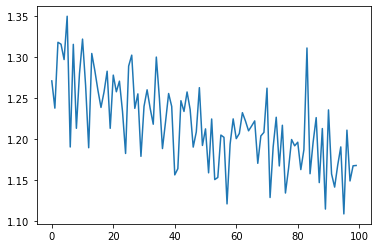

In [127]:
plt.figure()
plt.plot(all_losses)
plt.show()

In [128]:
# predict
def predict(input_line):
    print(f"\n> {input_line}")
    with torch.no_grad():
        line_tensor = line_to_tensor(input_line)
        hidden = rnn.init_hidden()
        
        for i in range(line_tensor.size()[0]):
            output, hidden = rnn(line_tensor[i], hidden)
            
        guess = category_from_output(output)
        print(guess)
        
while True:
    sentence = input("Input:")
    if sentence == "quit":
        break
        
    predict(sentence)

Input:i live on the moon

> i live on the moon
Greek
Input:i live in a box on the moon

> i live in a box on the moon
Arabic
Input:bao

> bao
Spanish
Input:bai

> bai
Italian
Input:brady

> brady
English
Input:currier

> currier
German
Input:fjaskag

> fjaskag
Greek
Input:quit


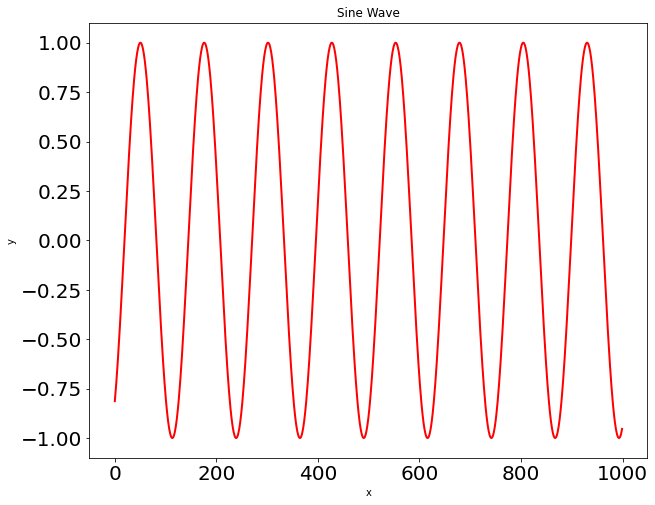

In [137]:
## PyTorch LSTM
N = 100
L = 1000
T = 20

x = np.empty((N, L), np.float32)
x[:] = np.array(range(L)) + np.random.randint(-4*T, 4*T, N).reshape(N, 1)
y = np.sin(x/1.0/T).astype(np.float32)

plt.figure(figsize=(10,8))
plt.title("Sine Wave")
plt.xlabel("x")
plt.ylabel("y")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(np.arange(x.shape[1]), y[0,:], 'r', linewidth=2.0)

In [138]:
# predictor
class LSTMPredictor(nn.Module):
    def __init__(self, n_hidden=51):
        super(LSTMPredictor, self).__init__()
        self.n_hidden = n_hidden
        
        self.lstm1 = nn.LSTMCell(1, self.n_hidden)
        self.lstm2 = nn.LSTMCell(self.n_hidden, self.n_hidden)
        self.linear = nn.Linear(self.n_hidden, 1)
        
    def forward(self, x, future=0):
        outputs = []
        n_samples = x.size(0)
        
        h_t = torch.zeros(n_samples, self.n_hidden, dtype=torch.float32)
        c_t = torch.zeros(n_samples, self.n_hidden, dtype=torch.float32)
        h_t2 = torch.zeros(n_samples, self.n_hidden, dtype=torch.float32)
        c_t2 = torch.zeros(n_samples, self.n_hidden, dtype=torch.float32)
        
        for input_t in x.split(1, dim=1):
            h_t, c_t = self.lstm1(input_t, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs.append(output)
            
        for i in range(future):
            h_t, c_t = self.lstm1(output, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs.append(output)
            
        outputs = torch.cat(outputs, dim=1)
        return(outputs)

Step 0
loss 0.4886627793312073
loss 0.48826801776885986
loss 0.4828895330429077
loss 0.4667396545410156
loss 0.4163409173488617
loss 0.3365492522716522
loss 0.3216850459575653
loss 0.301297128200531
loss 0.2536218762397766
loss 0.23336051404476166
loss 0.21732698380947113
loss 0.1934279203414917
loss 0.16405180096626282
loss 0.1368713080883026
loss 0.11415532976388931
loss 0.0955631285905838
loss 0.08071829378604889
loss 0.06905055791139603
loss 0.05988418310880661
loss 0.05262892320752144
test loss 0.045985788106918335
Step 1
loss 0.04683145880699158
loss 0.04215599223971367
loss 0.038354188203811646
loss 0.035240303725004196
loss 0.032673485577106476
loss 0.03054535947740078
loss 0.028771432116627693
loss 0.027285153046250343
loss 0.026033546775579453
loss 0.024974122643470764
loss 0.0240725576877594
loss 0.02330094762146473
loss 0.02263650670647621
loss 0.022060517221689224
loss 0.02155754528939724
loss 0.02111479826271534
loss 0.020721623674035072
loss 0.02036910504102707
loss 0.02

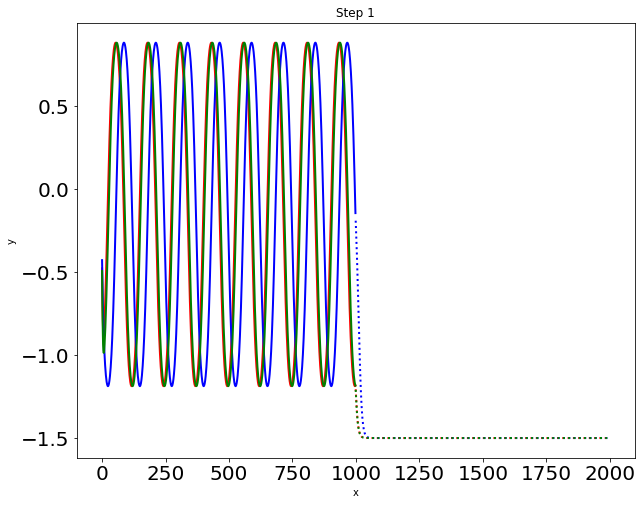

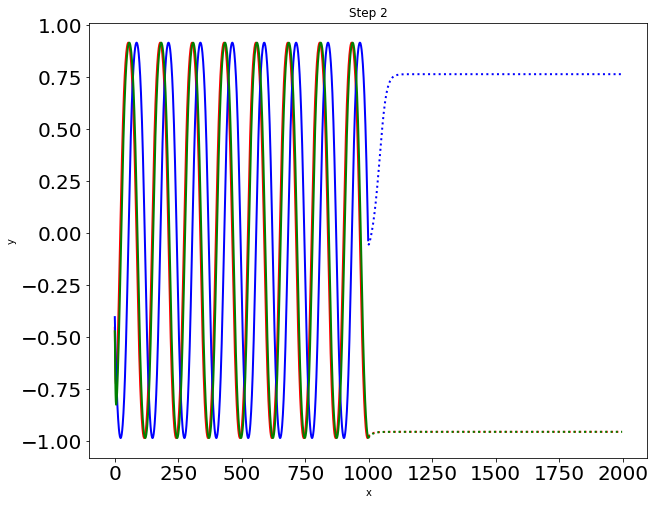

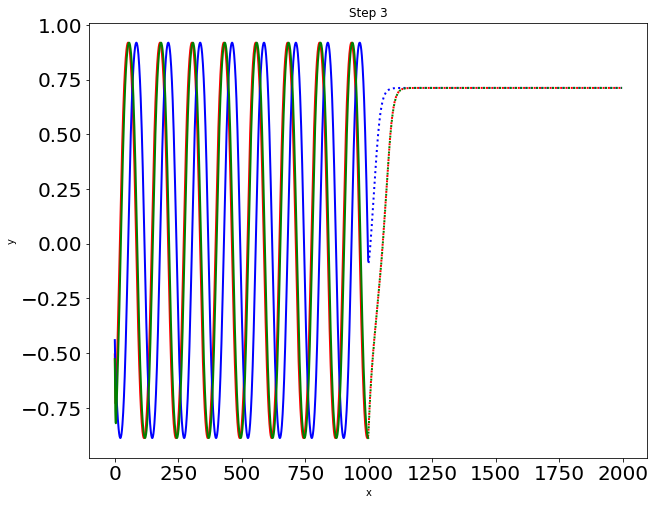

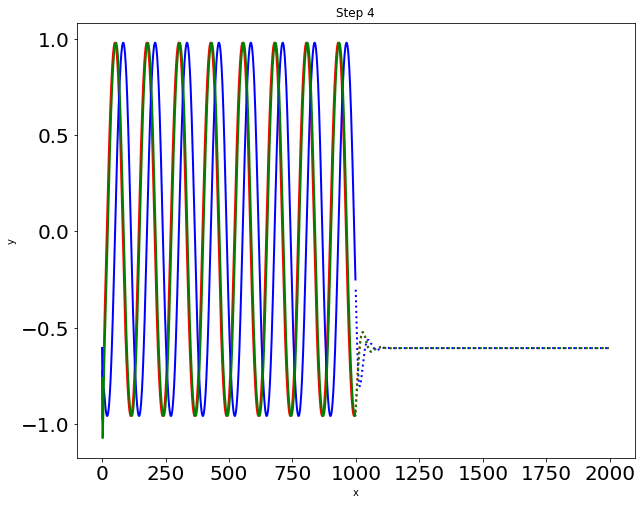

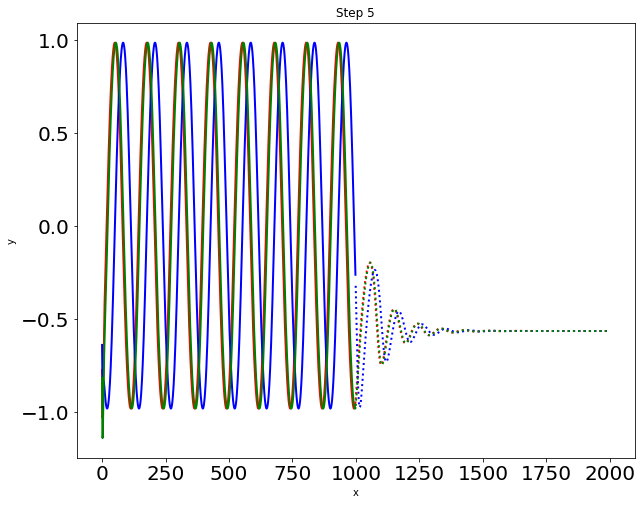

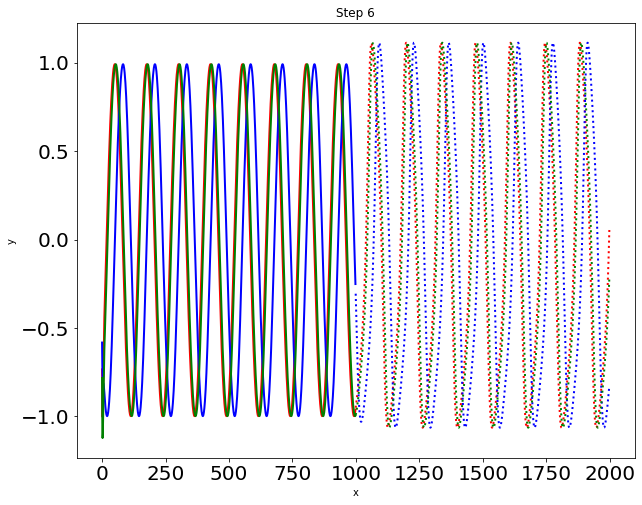

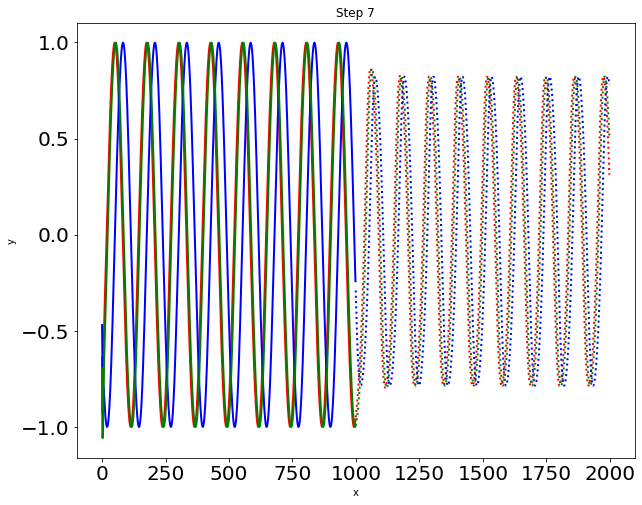

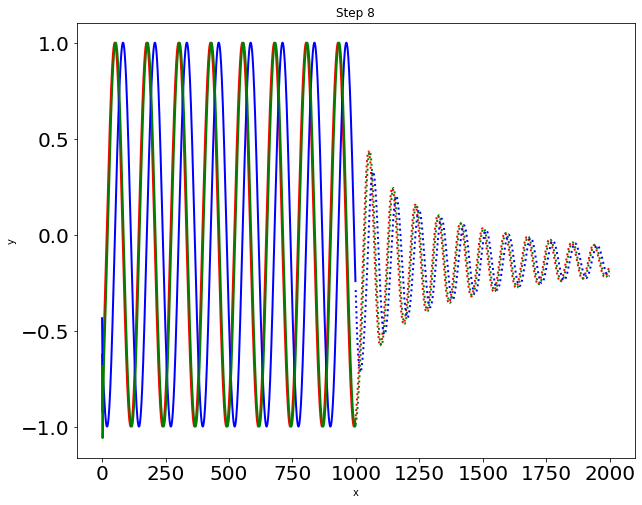

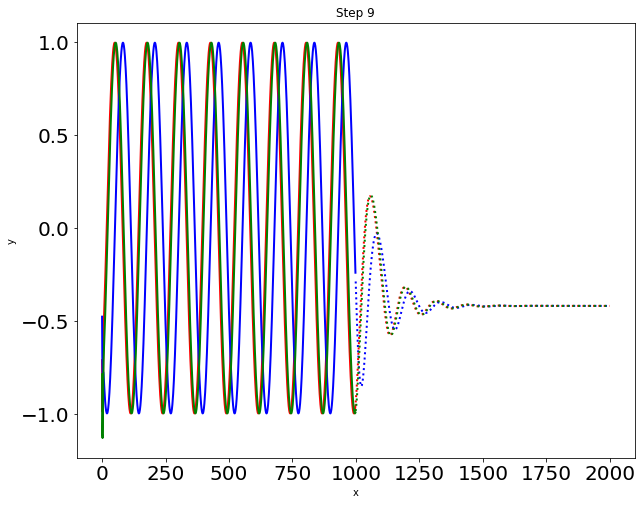

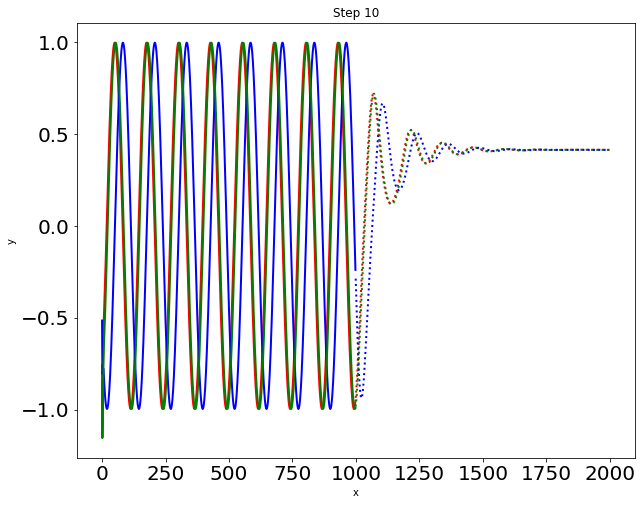

In [139]:
# training and predictions
train_input = torch.from_numpy(y[3:, :-1]) # 97, 999
train_target = torch.from_numpy(y[3:, 1:]) # 97, 999
test_input = torch.from_numpy(y[:3, :-1])  #  3, 999
test_target = torch.from_numpy(y[:3, 1:])  #  3, 999

model = LSTMPredictor()
criterion = nn.MSELoss()
optimizer = optim.LBFGS(model.parameters(), lr=0.08)

n_steps = 10
for i in range(n_steps):
    print("Step", i)
    
    def closure():
        optimizer.zero_grad()
        out = model(train_input)
        loss = criterion(out, train_target)
        print("loss", loss.item())
        loss.backward()
        return loss
    
    optimizer.step(closure)
    
    with torch.no_grad():
        future = 1000
        pred = model(test_input, future=future)
        loss = criterion(pred[:, :-future], test_target)
        print("test loss", loss.item())
        y = pred.detach().numpy()
    
    plt.figure(figsize=(10,8))
    plt.title(f"Step {i+1}")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    n = train_input.shape[1] # 999
    def draw(y_i, color):
        plt.plot(np.arange(n), y_i[:n], color, linewidth=2.0)
        plt.plot(np.arange(n, n+future), y_i[n:], color + ":", linewidth=2.0)
    draw(y[0],'r')
    draw(y[1],'b')
    draw(y[2],'g')

In [11]:
## PyTorch Encoder/Decoder

# load data
transform = transforms.ToTensor()
mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
data_loader = torch.utils.data.DataLoader(dataset=mnist_data,
                                         batch_size=64,
                                         shuffle=True)

In [12]:
# inspect data
dataiter = iter(data_loader)
images, labels = dataiter.next()
print(torch.min(images), torch.max(images))

tensor(0.) tensor(1.)


In [23]:
# autoencoder
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()        
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128), # (N, 784) -> (N, 128)
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3) # -> N, 3
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
class Autoencoder_CNN(nn.Module):
    def __init__(self):
        super().__init__() 
        # (N, 1, 28, 28)
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),  # (N, 16, 14, 14)
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # (N, 32, 7, 7)
            nn.ReLU(),
            nn.Conv2d(32, 64, 7)                       # (N, 64, 1, 1)
        )
        # (N, 64, 1, 1)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),             # (N, 32, 7, 7)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, 
                               padding=1, 
                               output_padding=1),      # (N, 16, 14, 14)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, 
                               padding=1, 
                               output_padding=1),      # (N, 1, 28, 28)   
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [24]:
# build model
model = Autoencoder_CNN()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [25]:
# training
num_epochs = 10
outputs = []
for epoch in range(num_epochs):
    for (img, _) in data_loader:
        #img = img.reshape(-1, 28*28)
        recon = model(img)
        loss = criterion(recon, img)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, img, recon))

Epoch:1, Loss:0.0106
Epoch:2, Loss:0.0058
Epoch:3, Loss:0.0045
Epoch:4, Loss:0.0035
Epoch:5, Loss:0.0035
Epoch:6, Loss:0.0032
Epoch:7, Loss:0.0028
Epoch:8, Loss:0.0031
Epoch:9, Loss:0.0025
Epoch:10, Loss:0.0026


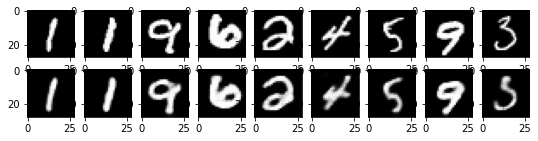

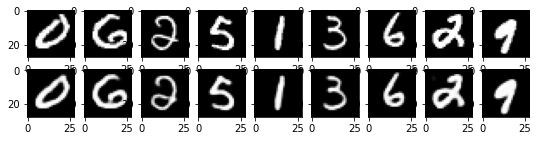

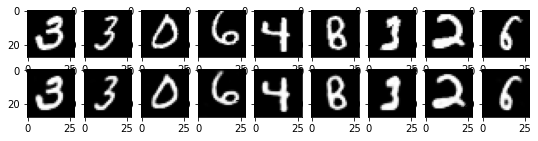

In [26]:
# show images
for k in range(0, num_epochs, 4):
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        #item = item.reshape(-1, 28,28)
        # item: 1, 28, 28
        plt.imshow(item[0])
            
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1) # row_length + i + 1
        #item = item.reshape(-1, 28,28)
        # item: 1, 28, 28
        plt.imshow(item[0])

In [86]:
## Audio Preprocessing Pipeline 

# load file
class Loader:
    
    def __init__(self, sample_rate, duration, mono):
        self.sample_rate = sample_rate
        self.duration = duration
        self.mono = mono
    
    def load(self, file_path):
        signal = librosa.load(file_path, 
                              sr=self.sample_rate, 
                              duration=self.duration,
                              mono=self.mono)[0]
        return signal

# pad signal if necessary
class Padder:
    
    def __init__(self, mode="constant"):
        self.mode = mode
        
    def left_pad(self, array, num_missing_items):
        padded_array = np.pad(array,
                             (num_missing_items, 0),
                             mode=self.mode)
        return padded_array
    
    def right_pad(self, array, num_missing_items):
        padded_array = np.pad(array,
                             (0, num_missing_items),
                             mode=self.mode)
        return padded_array
        

# take log spectrogram of signal
class LogSpectrogramExtractor:
    
    def __init__(self, frame_size, hop_length):
        self.frame_size = frame_size
        self.hop_length = hop_length
        
    def extract(self, signal):
        stft = librosa.stft(signal,
                           n_fft=self.frame_size,
                           hop_length=self.hop_length)[:-1]
        spectrogram = np.abs(stft)
        log_spectrogram = librosa.amplitude_to_db(spectrogram)
        return log_spectrogram

# normalize spectrogram
class MinMaxNormalizer:
    
    def __init__(self, min_val, max_val):
        self.min = min_val
        self.max = max_val
        
    def normalize(self, array):
        norm_array = (array - array.min()) / (array.max() - array.min())
        norm_array = norm_array * (self.max - self.min) + self.min
        return norm_array
    
    def denormalize(self, norm_array, original_min, original_max):
        array = (norm_array - self.min) / (self.max - self.min)
        array = array * (original_max - original_min) + original_min
        return array

# save features and min/max values
class Saver:
    
    def __init__(self, feature_save_dir, min_max_values_save_dir):
        self.feature_save_dir = feature_save_dir
        self.min_max_values_save_dir = min_max_values_save_dir
        
    def _generate_save_path(self, file_path):
        file_name = os.path.split(file_path)[1]
        save_path = os.path.join(self.feature_save_dir, file_name + ".npy")
        return save_path
    
    @staticmethod
    def _save(data, save_path):
        with open(save_path, "wb") as f:
            pickle.dump(data, f)
    
    def save_feature(self, feature, file_path):
        save_path = self._generate_save_path(file_path)
        np.save(save_path, feature)
        return save_path
        
    def save_min_max_values(self, min_max_values):
        save_path = os.path.join(self.min_max_values_save_dir, "min_max_values.pkl")
        self._save(min_max_values, save_path)

class PreprocessingPipeline:
    
    def __init__(self):
        self.padder = None
        self.extractor = None
        self.normalizer = None
        self.saver = None
        self.min_max_values = {}
        self._loader = None
        self._num_expected_samples = None
    
    @property
    def loader(self):
        return self._loader
    
    @loader.setter
    def loader(self, loader):
        self._loader = loader
        self._num_expected_samples = int(loader.sample_rate * loader.duration)
        
    def _is_padding_necessary(self, signal):
        if len(signal) < self._num_expected_samples:
            return True
        return False
    
    def _apply_padding(self, signal):
        num_missing_samples = self._num_expected_samples - len(signal)
        padded_signal = self.padder.right_pad(signal, num_missing_samples)
        return padded_signal
    
    def _store_min_max_value(self, save_path, min_val, max_val):
        self.min_max_values[save_path] = {
            "min": min_val,
            "max": max_val
        }
        
    def _process_file(self, file_path):
        signal = self.loader.load(file_path)
        if self._is_padding_necessary(signal):
            signal = self._apply_padding(signal)
        feature = self.extractor.extract(signal)
        norm_feature = self.normalizer.normalize(feature)
        save_path = self.saver.save_feature(norm_feature, file_path)
        self._store_min_max_value(save_path, feature.min(), feature.max())
        
    def process(self, audio_files_dir):
        for root, _, files in os.walk(audio_files_dir):
            for file in files:
                file_path = os.path.join(root, file)
                self._process_file(file_path)
        self.saver.save_min_max_values(self.min_max_values)


Opening dataset in read-only mode as you don't have write permissions.
hub://activeloop/spoken_mnist loaded successfully.
This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/spoken_mnist


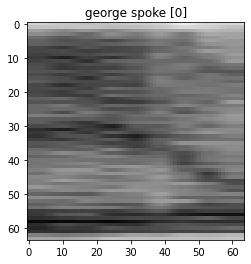

Dataset(path='hub://activeloop/spoken_mnist', read_only=True, tensors=['spectrograms', 'labels', 'audio', 'speakers'])


In [87]:
# load data
ds = hub.load("hub://activeloop/spoken_mnist")
plt.imshow(ds.spectrograms[0].numpy())
plt.title(f"{ds.speakers[0].data()} spoke {ds.labels[0].numpy()}")
plt.show()
print(ds)

In [89]:
# try it out
FRAME_SIZE = 512
HOP_LENGTH = 256
DURATION = 0.74 # seconds
SAMPLE_RATE = 22050
MONO = True

SPECTROGRAMS_SAVE_DIR = "/Users/Ry1/miniconda3/envs/AMTFinalProj/AMT-final-project-master/data/fsdd/spectrograms"
MIN_MAX_VALUES_SAVE_DIR = "/Users/Ry1/miniconda3/envs/AMTFinalProj/AMT-final-project-master/data/fsdd/"
FILES_DIR = "/Users/Ry1/miniconda3/envs/AMTFinalProj/AMT-final-project-master/data/fsdd/audio"

loader = Loader(SAMPLE_RATE, DURATION, MONO)
padder = Padder()
log_spectrogram_extractor = LogSpectrogramExtractor(FRAME_SIZE, HOP_LENGTH)
min_max_normalizer = MinMaxNormalizer(0, 1)
saver = Saver(SPECTROGRAMS_SAVE_DIR, MIN_MAX_VALUES_SAVE_DIR)

preprocessing_pipeline = PreprocessingPipeline()
preprocessing_pipeline.loader = loader
preprocessing_pipeline.padder = padder
preprocessing_pipeline.extractor = log_spectrogram_extractor
preprocessing_pipeline.normalizer = min_max_normalizer
preprocessing_pipeline.saver = saver

preprocessing_pipeline.process(FILES_DIR)

In [99]:
# we gon learn today

class CombinedLoss(tf.keras.losses.Loss):
    
    def __init__(self, rho, mu, sig):
        super(CombinedLoss, self).__init__()
        self.rho = rho
        self.mu = mu
        self.sig = sig

    def call(self, y_true, y_pred):
        mse = K.mean(K.square(y_true - y_pred), axis=[1, 2, 3])
        kl = -0.5 * K.sum(1 + self.sig - K.square(self.mu) - K.exp(self.sig), axis=1)
        return self.rho * mse + kl

class VAE:
    """
    VAE represents a Deep Convolutional variational autoencoder architecture
    with mirrored encoder and decoder components.
    """

    def __init__(self,
                 input_shape,
                 conv_filters,
                 conv_kernels,
                 conv_strides,
                 latent_space_dim):
        self.input_shape = input_shape # [28, 28, 1]
        self.conv_filters = conv_filters # [2, 4, 8]
        self.conv_kernels = conv_kernels # [3, 5, 3]
        self.conv_strides = conv_strides # [1, 2, 2]
        self.latent_space_dim = latent_space_dim # 2
        self.reconstruction_loss_weight = 1000000

        self.encoder = None
        self.decoder = None
        self.model = None

        self._num_conv_layers = len(conv_filters)
        self._shape_before_bottleneck = None
        self._model_input = None

        self._build()

    def summary(self):
        self.encoder.summary()
        self.decoder.summary()
        self.model.summary()

    def compile(self, learning_rate=0.0001):
        optimizer = Adam(learning_rate=learning_rate)
        combined_loss = CombinedLoss(self.reconstruction_loss_weight, 
                                     self.mu, 
                                     self.log_variance)
        self.model.compile(optimizer=optimizer,
                           loss=combined_loss,
                           metrics=[Metrics.MeanSquaredError(),
                                    Metrics.KLDivergence()])

    def train(self, x_train, batch_size, num_epochs):
        self.model.fit(x_train,
                       x_train,
                       batch_size=batch_size,
                       epochs=num_epochs,
                       shuffle=True)

    def save(self, save_folder="."):
        self._create_folder_if_it_doesnt_exist(save_folder)
        self._save_parameters(save_folder)
        self._save_weights(save_folder)

    def load_weights(self, weights_path):
        self.model.load_weights(weights_path)

    def reconstruct(self, images):
        latent_representations = self.encoder.predict(images)
        reconstructed_images = self.decoder.predict(latent_representations)
        return reconstructed_images, latent_representations

    @classmethod
    def load(cls, save_folder="."):
        parameters_path = os.path.join(save_folder, "parameters.pkl")
        with open(parameters_path, "rb") as f:
            parameters = pickle.load(f)
        autoencoder = VAE(*parameters)
        weights_path = os.path.join(save_folder, "weights.h5")
        autoencoder.load_weights(weights_path)
        return autoencoder

    def _create_folder_if_it_doesnt_exist(self, folder):
        if not os.path.exists(folder):
            os.makedirs(folder)

    def _save_parameters(self, save_folder):
        parameters = [
            self.input_shape,
            self.conv_filters,
            self.conv_kernels,
            self.conv_strides,
            self.latent_space_dim
        ]
        save_path = os.path.join(save_folder, "parameters.pkl")
        with open(save_path, "wb") as f:
            pickle.dump(parameters, f)

    def _save_weights(self, save_folder):
        save_path = os.path.join(save_folder, "weights.h5")
        self.model.save_weights(save_path)

    def _build(self):
        self._build_encoder()
        self._build_decoder()
        self._build_autoencoder()

    def _build_autoencoder(self):
        model_input = self._model_input
        model_output = self.decoder(self.encoder(model_input))
        self.model = Model(model_input, model_output, name="autoencoder")

    def _build_decoder(self):
        decoder_input = self._add_decoder_input()
        dense_layer = self._add_dense_layer(decoder_input)
        reshape_layer = self._add_reshape_layer(dense_layer)
        conv_transpose_layers = self._add_conv_transpose_layers(reshape_layer)
        decoder_output = self._add_decoder_output(conv_transpose_layers)
        self.decoder = Model(decoder_input, decoder_output, name="decoder")

    def _add_decoder_input(self):
        return Input(shape=self.latent_space_dim, name="decoder_input")

    def _add_dense_layer(self, decoder_input):
        num_neurons = np.prod(self._shape_before_bottleneck) # [1, 2, 4] -> 8
        dense_layer = Dense(num_neurons, name="decoder_dense")(decoder_input)
        return dense_layer

    def _add_reshape_layer(self, dense_layer):
        return Reshape(self._shape_before_bottleneck)(dense_layer)

    def _add_conv_transpose_layers(self, x):
        """Add conv transpose blocks."""
        # loop through all the conv layers in reverse order and stop at the
        # first layer
        for layer_index in reversed(range(1, self._num_conv_layers)):
            x = self._add_conv_transpose_layer(layer_index, x)
        return x

    def _add_conv_transpose_layer(self, layer_index, x):
        layer_num = self._num_conv_layers - layer_index
        conv_transpose_layer = Conv2DTranspose(
            filters=self.conv_filters[layer_index],
            kernel_size=self.conv_kernels[layer_index],
            strides=self.conv_strides[layer_index],
            padding="same",
            name=f"decoder_conv_transpose_layer_{layer_num}"
        )
        x = conv_transpose_layer(x)
        x = ReLU(name=f"decoder_relu_{layer_num}")(x)
        x = BatchNormalization(name=f"decoder_bn_{layer_num}")(x)
        return x

    def _add_decoder_output(self, x):
        conv_transpose_layer = Conv2DTranspose(
            filters=1,
            kernel_size=self.conv_kernels[0],
            strides=self.conv_strides[0],
            padding="same",
            name=f"decoder_conv_transpose_layer_{self._num_conv_layers}"
        )
        x = conv_transpose_layer(x)
        output_layer = Activation("sigmoid", name="sigmoid_layer")(x)
        return output_layer

    def _build_encoder(self):
        encoder_input = self._add_encoder_input()
        conv_layers = self._add_conv_layers(encoder_input)
        bottleneck = self._add_bottleneck(conv_layers)
        self._model_input = encoder_input
        self.encoder = Model(encoder_input, bottleneck, name="encoder")

    def _add_encoder_input(self):
        return Input(shape=self.input_shape, name="encoder_input")

    def _add_conv_layers(self, encoder_input):
        """Create all convolutional blocks in encoder."""
        x = encoder_input
        for layer_index in range(self._num_conv_layers):
            x = self._add_conv_layer(layer_index, x)
        return x

    def _add_conv_layer(self, layer_index, x):
        """Add a convolutional block to a graph of layers, consisting of
        conv 2d + ReLU + batch normalization.
        """
        layer_number = layer_index + 1
        conv_layer = Conv2D(
            filters=self.conv_filters[layer_index],
            kernel_size=self.conv_kernels[layer_index],
            strides=self.conv_strides[layer_index],
            padding="same",
            name=f"encoder_conv_layer_{layer_number}"
        )
        x = conv_layer(x)
        x = ReLU(name=f"encoder_relu_{layer_number}")(x)
        x = BatchNormalization(name=f"encoder_bn_{layer_number}")(x)
        return x

    def _add_bottleneck(self, x):
        """Flatten data and add bottleneck with Guassian sampling (Dense
        layer).
        """
        self._shape_before_bottleneck = K.int_shape(x)[1:]
        x = Flatten()(x)
        self.mu = Dense(self.latent_space_dim, name="mu")(x)
        self.log_variance = Dense(self.latent_space_dim,
                                  name="log_variance")(x)

        def sample_point_from_normal_distribution(args):
            mu, log_variance = args
            epsilon = K.random_normal(shape=K.shape(self.mu), mean=0.,
                                      stddev=1.)
            sampled_point = mu + K.exp(log_variance / 2) * epsilon
            return sampled_point

        x = Lambda(sample_point_from_normal_distribution,
                   name="encoder_output")([self.mu, self.log_variance])
        return x
    

LEARNING_RATE  = 0.0005
BATCH_SIZE = 64
EPOCHS = 150

def load_fsdd(spectrograms_path):
    x_train = []
    for root, _, file_names in os.walk(spectrograms_path):
        for file_name in file_names:
            file_path = os.path.join(root, file_name)
            spectrogram = np.load(file_path)
            x_train.append(spectrogram)
    x_train = np.array(x_train)
    x_train = x_train[..., np.newaxis]
    return x_train

def train(x_train, learning_rate, batch_size, epochs):
    autoencoder = VAE(
        input_shape=(256, 64, 1),
        conv_filters=(512, 256, 128, 64, 32),
        conv_kernels=(3, 3, 3, 3, 3),
        conv_strides=(2, 2, 2, 2, (2, 1)),
        latent_space_dim=128
    )
    #autoencoder.summary()
    autoencoder.compile(learning_rate)
    autoencoder.train(x_train, batch_size, epochs)
    return autoencoder
    
x_train = load_fsdd("/Users/Ry1/miniconda3/envs/AMTFinalProj/AMT-final-project-master/data/fsdd/spectrograms")
autoencoder = train(x_train, LEARNING_RATE, BATCH_SIZE, EPOCHS)
autoencoder.save("model")

Train on 3000 samples
Epoch 1/150
3000/3000 [==============================] - 449s 150ms/sample - loss: 129877.5951 - mean_squared_error: 0.1291 - kullback_leibler_divergence: -0.0317
Epoch 2/150
3000/3000 [==============================] - 447s 149ms/sample - loss: 38523.5627 - mean_squared_error: 0.0379 - kullback_leibler_divergence: -0.0213
Epoch 3/150
3000/3000 [==============================] - 452s 151ms/sample - loss: 28999.3503 - mean_squared_error: 0.0286 - kullback_leibler_divergence: -0.0155
Epoch 4/150
3000/3000 [==============================] - 451s 150ms/sample - loss: 26545.2079 - mean_squared_error: 0.0262 - kullback_leibler_divergence: -0.0155
Epoch 5/150
3000/3000 [==============================] - 445s 148ms/sample - loss: 25709.2271 - mean_squared_error: 0.0254 - kullback_leibler_divergence: -0.0159
Epoch 6/150
3000/3000 [==============================] - 418s 139ms/sample - loss: 25288.7329 - mean_squared_error: 0.0250 - kullback_leibler_divergence: -0.0162
Epoch

In [100]:
## makea sound
class SoundGenerator:
    
    def __init__(self, vae, hop_length):
        self.vae = vae
        self.hop_length = hop_length
        self.min_max_normalizer = MinMaxNormalizer(0, 1)
        
    def generate(self, spectrograms, min_max_values):
        generated_spectrograms, latent_representations = self.vae.reconstruct(spectrograms)
        signals = self.convert_spectrograms_to_audio(generated_spectrograms, min_max_values)
        return signals, latent_representations
    
    def convert_spectrograms_to_audio(self, spectrograms, min_max_values):
        signals = []
        for spectrogram, min_max_value in zip(spectrograms, min_max_values):
            # reshape
            log_spectrogram = spectrogram[:, :, 0]
            # denormalize
            denorm_log_spec = self.min_max_normalizer.denormalize(
                log_spectrogram, 
                min_max_value["min"],
                min_max_value["max"])
            # exponentiate
            spec = librosa.db_to_amplitude(denorm_log_spec)
            # ISTFT
            signal = librosa.istft(spec, hop_length=self.hop_length)
            # append to list
            signals.append(signal)
        return signals
    
HOP_LENGTH = 256
SAVE_DIR_ORIGINAL = "/Users/Ry1/miniconda3/envs/AMTFinalProj/AMT-final-project-master/samples/original/"
SAVE_DIR_GENERATED = "/Users/Ry1/miniconda3/envs/AMTFinalProj/AMT-final-project-master/samples/generated/"
MIN_MAX_VALUES_PATH = "/Users/Ry1/miniconda3/envs/AMTFinalProj/AMT-final-project-master/data/fsdd/min_max_values.pkl"

def fsdd_load(spectrograms_path):
    x_train = []
    file_paths = []
    for root, _, file_names in os.walk(spectrograms_path):
        for file_name in file_names:
            file_path = os.path.join(root, file_name)
            spectrogram = np.load(file_path)
            x_train.append(spectrogram)
            file_paths.append(file_path)
    x_train = np.array(x_train)
    x_train = x_train[..., np.newaxis]
    return x_train, file_paths

def select_spectrograms(spectrograms, file_paths, min_max_values, num_spectrograms=2):
    sampled_indices = np.random.choice(range(len(spectrograms)), num_spectrograms)
    sampled_spectrograms = spectrograms[sampled_indices]
    file_paths = [file_paths[index] for index in sampled_indices]
    sampled_min_max_values = [min_max_values[file_path] for file_path in file_paths]
    
    print(file_paths)
    print(sampled_min_max_values)
    return sampled_spectrograms, sampled_min_max_values

def save_signals(signals, save_dir, sample_rate=22050):
    for i, signal in enumerate(signals):
        save_path = os.path.join(save_dir + str(i) + ".wav")
        sf.write(save_path, signal, sample_rate)

sound_generator = SoundGenerator(autoencoder, HOP_LENGTH)

with open(MIN_MAX_VALUES_PATH, "rb") as f:
    min_max_values = pickle.load(f)
    
specs, file_paths = fsdd_load(SPECTROGRAMS_SAVE_DIR)
sampled_specs, sampled_min_max_values = select_spectrograms(specs, 
                                                            file_paths, 
                                                            min_max_values, 
                                                            5)
signals, _ = sound_generator.generate(sampled_specs, sampled_min_max_values)
original_signals = sound_generator.convert_spectrograms_to_audio(sampled_specs, 
                                                                 sampled_min_max_values)
save_signals(signals, SAVE_DIR_GENERATED)
save_signals(original_signals, SAVE_DIR_ORIGINAL)
        

['/Users/Ry1/miniconda3/envs/AMTFinalProj/AMT-final-project-master/data/fsdd/spectrograms/6_nicolas_32.wav.npy', '/Users/Ry1/miniconda3/envs/AMTFinalProj/AMT-final-project-master/data/fsdd/spectrograms/5_yweweler_2.wav.npy', '/Users/Ry1/miniconda3/envs/AMTFinalProj/AMT-final-project-master/data/fsdd/spectrograms/9_jackson_42.wav.npy', '/Users/Ry1/miniconda3/envs/AMTFinalProj/AMT-final-project-master/data/fsdd/spectrograms/7_george_9.wav.npy', '/Users/Ry1/miniconda3/envs/AMTFinalProj/AMT-final-project-master/data/fsdd/spectrograms/3_nicolas_24.wav.npy']
[{'min': -55.577717, 'max': 24.422283}, {'min': -66.82631, 'max': 13.173694}, {'min': -55.546432, 'max': 24.453568}, {'min': -53.262337, 'max': 26.737661}, {'min': -64.37895, 'max': 15.621052}]
